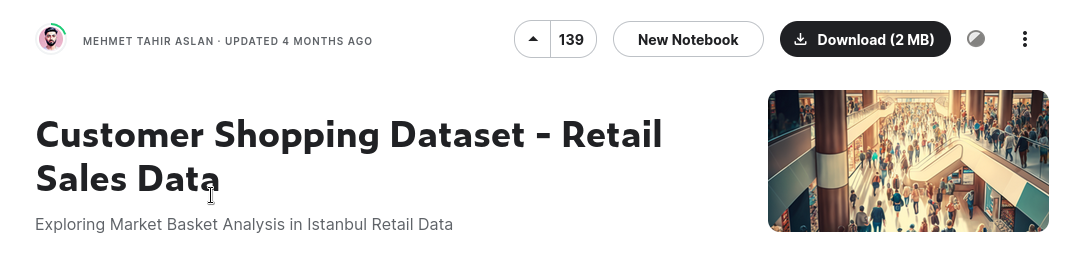

The first place to search for a dataset that came to mind was *Kaggle*. [this transactional dataset](https://www.kaggle.com/datasets/vivek468/superstore-dataset-final) was chosen. It depicts shopping information from 10 different shopping malls between 2021 and 2023. It contains gathered data from various age groups and genders to provide a comprehensive view of shopping habits in Istanbul.

#### Suppose that we are a business that is interested in running a supermarket franchise/net in Istanbul.
We need as much data as possible on running stores of our competitors, customer preferences, sales within different product categories, etc.

Lets take a brief look at the dataset:

In [31]:
import os
import pandas as pd
import numpy as np

In [32]:
# os.getcwd()
# os.chdir('DWH Project')

In [202]:
df = pd.read_csv('customer_shopping_data.csv')

In [34]:
df.shape

(99457, 10)

*Note: needs to be augmented by 10 times* 

In [35]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


Original dataset's attribute information:

* **invoice_no**: Invoice number. Nominal. A combination of the letter 'I' and a 6 to 7-digit integer uniquely assigned to each operation.
* **customer_id**: Customer number. Nominal. A combination of the letter 'C' and a 6-digit integer uniquely assigned to each customer.
* **gender**: String variable of the customer's gender.
* **age**: Positive Integer variable of the customers age.
* **category**: String variable of the category of the purchased product.
* **quantity**: The quantities of each product (item) per transaction. Numeric.
* **price**: Unit price. Numeric. Product price per unit in Turkish Liras (TL).
* **payment_method**: String variable of the payment method (cash, credit card or debit card) used for the transaction.
* **invoice_date**: Invoice date. The day when a transaction was generated.
* **shopping_mall**: String variable of the name of the shopping mall where the transaction was made.


That is definitely not enough, further augmentation in size & dimensionality is required

Here are some of the new dimensions & features artificially added to a dataset:

Added attributes information:
 - **discount** - total discount per transaction
 - **coupon_id** - coupon, on which discount is based
 - **revenue** - mall's total revenue from a transaction
 - **costs** - mall's total costs per transaction
 - **company_name** - Name of the company that owns the store
 - **district** - district of Istanbul, in which the store is located
 - **lat/long** - geographical coordnates of shops
 - **customer_name** - customer's full name (mapped to customer_id)
 - **customer_rating** - customer's rating of services in different shopping malls
 - **payment_amount** - customer's total check per transaction

*It would be nice to have some sort of cost measure, since this dataset does not contain such information, the column will be generated:*

In [203]:
df['costs'] = round(df['price']*df['quantity']*np.random.uniform(0.8, 1.025), 2)

The costs will be equal to price time quantity times *a random number from uniform distribution*.

*Add a discount system*

In [204]:
from random import choice
# chooser = lambda x: choice([np.random.randint(1, 10), np.nan])
def chooser(x):
    return int(choice([np.random.randint(10000, 10009), -1]))
df['coupon_id'] = df.apply(chooser, axis = 1)

*TODO: use a weighted choice in favor of discount absence, add coupon_type*

In [205]:
# map coupon_ids to discount sizes
discount_factors = {-1: 0, 10000: 0.1, 10001: 0.12, 10002: 0.15, 10003: 0.05, 10004: 0.08, 10005: 0, 10006: 0, 10007: 0, 10008: 0.2, 10009: 0.3}
df['discount'] = round(df['coupon_id'].map(discount_factors) * df['price'] * df['quantity'], 2)

*Add payment_amount*

In [224]:
df['payment_amount'] = df['price']*df['quantity'] - df['discount']

*Add companies/owners of shops*

In [206]:
# df['shopping_mall'].unique()
# map companies to shops
companies = {'Kanyon': 'Ankara Goods', 'Forum Istanbul': 'Turkish Goods', 'Metrocity': 'AnkorTech', 'Metropol AVM': 'AnkorTech', 'Istinye Park': 'Turkish Goods', 'Mall of Istanbul': 'Istanbul Groceries INC.', 'Emaar Square Mall': 'Istanbul Groceries INC.', 'Cevahir AVM': 'Cevahir', 'Viaport Outlet': 'Ankara Goods', 'Zorlu Center': 'Ankara Goods'}
df['company_name'] = df['shopping_mall'].map(companies)

*Add Istanbul districts & store coordinates*

In [207]:
# mapping with shopping malls
districts = {'Kanyon': 'Beshiktash', 'Forum Istanbul': 'Tansim', 'Metrocity': 'Levent', 'Metropol AVM': 'Karakoy', 'Istinye Park': 'Fatih', 'Mall of Istanbul': 'Fatih', 'Emaar Square Mall': 'Sultanahmet', 'Cevahir AVM': 'Sultanahmet', 'Viaport Outlet': 'Uskudar', 'Zorlu Center': 'Uskudar'}
df['district'] = df['shopping_mall'].map(districts)

In [208]:
# generating location
districts = df['district'].unique()
lat_map = {district:41.015137*np.random.uniform(0.999, 1.001) for district in districts}
long_map = {district:28.979530*np.random.uniform(0.995, 1.005) for district in districts}
df['lat'] = df['district'].map(lat_map)
df['long'] = df['district'].map(long_map)

*Add a revenue column*

In [209]:
df['revenue'] = round(df['price']*df['quantity'] - df['discount'] - df['costs'], 2)

*Add Customer Ratings using weights mask*

In [221]:
df['customer_rating'] = np.random.randint(1,6, len(df))
df.loc[np.random.choice([True, False], len(df), p = [0.95, 1 - 0.95]), 'customer_rating'] = -1

### Augment this dataset 11x by copying itself

*Also Remove duplicates from invoice_no column, transoform invoice_date into TIMESTAMP*

In [210]:
# Augmenting data frame without PK
invoice_ids = df['invoice_no']
df = pd.concat([df.drop(columns=['invoice_no'])]*11, ignore_index=True)

In [211]:
# generating unique keys & assigning them to new rows, to preserve the invoice_no column
df['invoice_no'] = invoice_ids
new_keys = pd.Series(np.arange(100000, 1200000, dtype = int))
new_keys_series = pd.Series(['IO' + str(i) for i in new_keys])
df['invoice_no'] = df['invoice_no'].fillna(value=new_keys_series)

In [212]:
# Convert Date column to pandas datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='mixed')

In [213]:
# Add artificial timestamps
df['invoice_date'] = df['invoice_date'].apply(lambda x: x + pd.Timedelta(hours=np.random.randint(8, 23), minutes=np.random.randint(0, 60), seconds=np.random.randint(0, 60)))

In [215]:
# Rename invoice_date to timestamp
df = df.rename(columns={'invoice_date':'timestamp'})

### Splitting the dataset into two, by using the following method:

- **The first data source (sales_dataset_1) would be customers payment by card information, that is partially taken & then merged into a single csv from some imaginary system of card transaction processing. It contains customer & payment information & some duplicating information like the shopping_mall id/name.**

- **The second data source (sales_dataset_2) would be the invoices data merged together with some additional information provided/taken from shopping malls and scrapped online.**

- **Obviously there are plenty of logical pitfalls**

In [225]:
# Data from the card payments
sales_dataset_1 = df[['customer_id', 'gender', 'age', 'payment_method', 'payment_amount', 'shopping_mall', 'timestamp']]
sales_dataset_1 = sales_dataset_1[sales_dataset_1['payment_method'].isin(['Credit Card', 'Debit Card'])]
# Invoice data
sales_dataset_2 = df[['invoice_no', 'customer_id', 'category', 'payment_method', 'coupon_id', 'discount', 'quantity', 'price', 'costs', 'revenue', 'timestamp', 'shopping_mall', 'district', 'lat', 'long', 'company_name', 'customer_rating']]

Sales dataset 2 should be further modified to ensure the uniqueness of two

*Add customer_name column*

In [226]:
# generate customer_name column using faker lib
from faker import Faker
fake = Faker()
sales_dataset_1['customer_name'] = sales_dataset_1 \
    .groupby('customer_id') \
    .apply(lambda x: fake.name().upper()) \
    .reset_index(drop=True)

#### Resultant datasets

In [229]:
sales_dataset_1.head()

,customer_id,gender,age,payment_method,payment_amount,shopping_mall,timestamp,customer_name
0,C241288,Female,28,Credit Card,7502.00,Kanyon,2022-05-08 11:09:01,JEREMIAH WILSON
1,C111565,Male,21,Debit Card,5401.53,Forum Istanbul,2021-12-12 20:30:30,KATHERINE FLOWERS
3,C988172,Female,66,Credit Card,15004.25,Metropol AVM,2021-05-16 12:41:38,PATRICIA RYAN
5,C657758,Female,28,Credit Card,7126.90,Forum Istanbul,2022-05-24 14:46:35,MICHAEL ROGERS
7,C176086,Female,32,Credit Card,1200.32,Mall of Istanbul,2021-01-13 20:07:29,LYNN HOLLAND


In [232]:
sales_dataset_2.head()

,invoice_no,customer_id,category,payment_method,coupon_id,discount,quantity,price,costs,revenue,timestamp,shopping_mall,district,lat,long,company_name,customer_rating
0,I138884,C241288,Clothing,Credit Card,10005,0.0,5,1500.40,6972.20,529.80,2022-05-08 11:09:01,Kanyon,Beshiktash,41.045724,28.864902,Ankara Goods,5
1,I317333,C111565,Shoes,Debit Card,-1,0.0,3,1800.51,5020.06,381.47,2021-12-12 20:30:30,Forum Istanbul,Tansim,41.015563,28.938431,Turkish Goods,-1
2,I127801,C266599,Clothing,Cash,-1,0.0,1,300.08,278.89,21.19,2021-09-11 16:26:50,Metrocity,Levent,41.033524,28.985252,AnkorTech,-1
3,I173702,C988172,Shoes,Credit Card,-1,0.0,5,3000.85,13944.62,1059.63,2021-05-16 12:41:38,Metropol AVM,Karakoy,41.005693,29.082513,AnkorTech,-1
4,I337046,C189076,Books,Cash,-1,0.0,4,60.60,225.28,17.12,2021-10-24 13:09:11,Kanyon,Beshiktash,41.045724,28.864902,Ankara Goods,-1
